# Exploratory analysis on volume correlations

In [91]:
from itertools import combinations, combinations_with_replacement

import graspologic as gp
import hyppo
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from hyppo.ksample import MANOVA, KSample
from matplotlib.transforms import Bbox
from scipy.stats import kruskal, mannwhitneyu, wilcoxon
from seaborn.utils import relative_luminance
from statsmodels.stats.multitest import multipletests

from pkg.data import (
    GENOTYPES,
    HEMISPHERES,
    SUB_STRUCTURES,
    SUPER_STRUCTURES,
    load_fa_corr,
    load_vertex_df,
    load_vertex_metadata,
    load_volume_corr,
)
from pkg.plot import plot_heatmaps
from pkg.utils import squareize

matplotlib.rcParams["font.family"] = "monospace"

## Plot the data

In [3]:
# Load the data

correlations, labels = load_volume_corr()

meta = load_vertex_df()

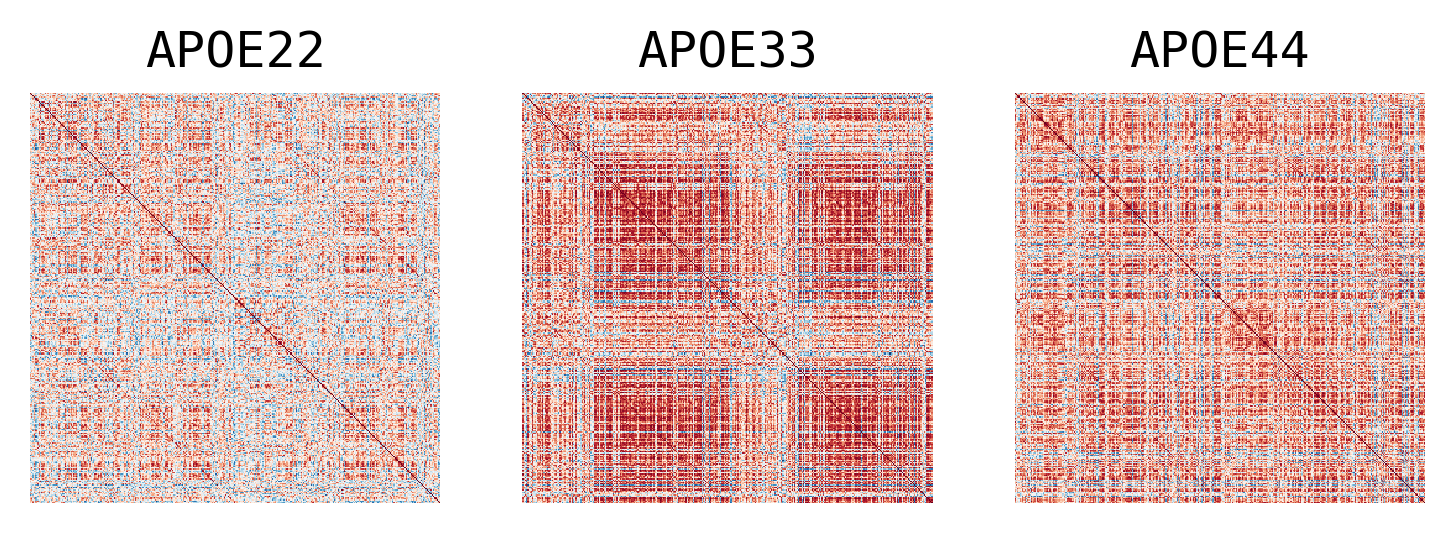

In [4]:
## Plot to make sure nothing is wrong
fig, ax = plt.subplots(1, 3, figsize=(6, 2), dpi=300)

for idx, label in enumerate(labels):
    sns.heatmap(
        correlations[idx],
        ax=ax[idx],
        vmin=-1,
        vmax=1,
        cbar=False,
        cmap="RdBu_r",
        xticklabels=False,
        yticklabels=False,
        center=0,
        square=True,
    )
    ax[idx].set(title=label)

## Vectorize matrix and compute kruskal-wallis

We use KW test for speed since computing large distance distance matrices can be difficult to compute.

In [5]:
# use kruskal-wallis for speed

idx = np.triu_indices_from(correlations[0], k=1)

kruskal(*[c[idx] for c in correlations])

KruskalResult(statistic=9669.864712617768, pvalue=0.0)

## Try apriori community

In [6]:
def group_labels(
    vertex_labels,
):
    out = []

    uniques = np.unique(vertex_labels)

    for pair in combinations_with_replacement(uniques, 2):
        rdx = vertex_labels == pair[0]
        cdx = vertex_labels == pair[1]

        out.append(
            [pair, (rdx, cdx)],
        )

    return out


def run_test(
    graphs, vertex_labels, hierarchy_level, test="kruskal", absolute=False, reps=1000
):
    """
    hierarchy_level : int
        0 is top level, 1 is next, etc
    """
    num_graphs = len(graphs)

    pairs = group_labels(vertex_labels)

    out = []
    for pair, (rdx, cdx) in pairs:
        num_verts = np.max([rdx.sum(), cdx.sum()])
        triu_idx = np.triu_indices(num_verts, k=1)

        if not np.all(rdx == cdx):  # deal with off diagonal blocks
            to_test = [g[rdx, :][:, cdx].ravel() for g in graphs]
        else:  # when main diagonal block, only use upper triangle
            to_test = [g[rdx, :][:, cdx][triu_idx] for g in graphs]

        if absolute:
            to_test = [np.abs(t) for t in to_test]

        if to_test[0].size <= 3:
            res = [np.nan, np.nan]
        else:
            if test.lower() == "dcorr":
                res = KSample("Dcorr").test(*to_test, auto=False, reps=reps, workers=-1)
            elif test.lower() == "kruskal":
                res = kruskal(*to_test)
            elif test.lower() == "manova":
                res = MANOVA().test(*to_test)
        # res = tester(*[np.abs(i) for i in to_test])
        stat, pval = res[:2]

        to_append = [*pair, stat, pval, hierarchy_level]
        out.append(to_append)

    columns = ["region1", "region2", "statistic", "pvalue", "hierarchy_level"]
    df = pd.DataFrame(out, columns=columns)

    non_nan = ~df.pvalue.isna()
    is_sig, corrected_pvalues, _, _ = multipletests(df[non_nan].pvalue, method="fdr_bh")
    df.loc[non_nan, "corrected_pvalue"] = corrected_pvalues
    df.loc[non_nan, "significant"] = is_sig

    return df

In [7]:
vertex_hemispheres = meta.Hemisphere.values
vertex_structures = meta.Level_1.values
vertex_hemisphere_structures = (meta.Hemisphere + "-" + meta.Level_1).values
vertex_hemisphere_substructures = (
    meta.Hemisphere + "-" + meta.Level_1 + "-" + meta.Level_2
).values

dfs = [
    run_test(correlations, labels, idx, test="manova", absolute=True)
    for idx, labels in enumerate(
        [
            vertex_hemispheres,
            vertex_structures,
            vertex_hemisphere_structures,
            vertex_hemisphere_substructures,
        ]
    )
]

dfs = pd.concat(dfs, ignore_index=True)

In [8]:
dfs.to_csv("../results/outputs/volume_correlation_3sample_apriori.csv", index=False)

/mnt/nfs2/j1c/badea-mouse/pkg/pkg/plot/ksample.py:54: RuntimeWarning: divide by zero encountered in log10
  plot_pvalues[np.isinf(plot_pvalues)] = -150


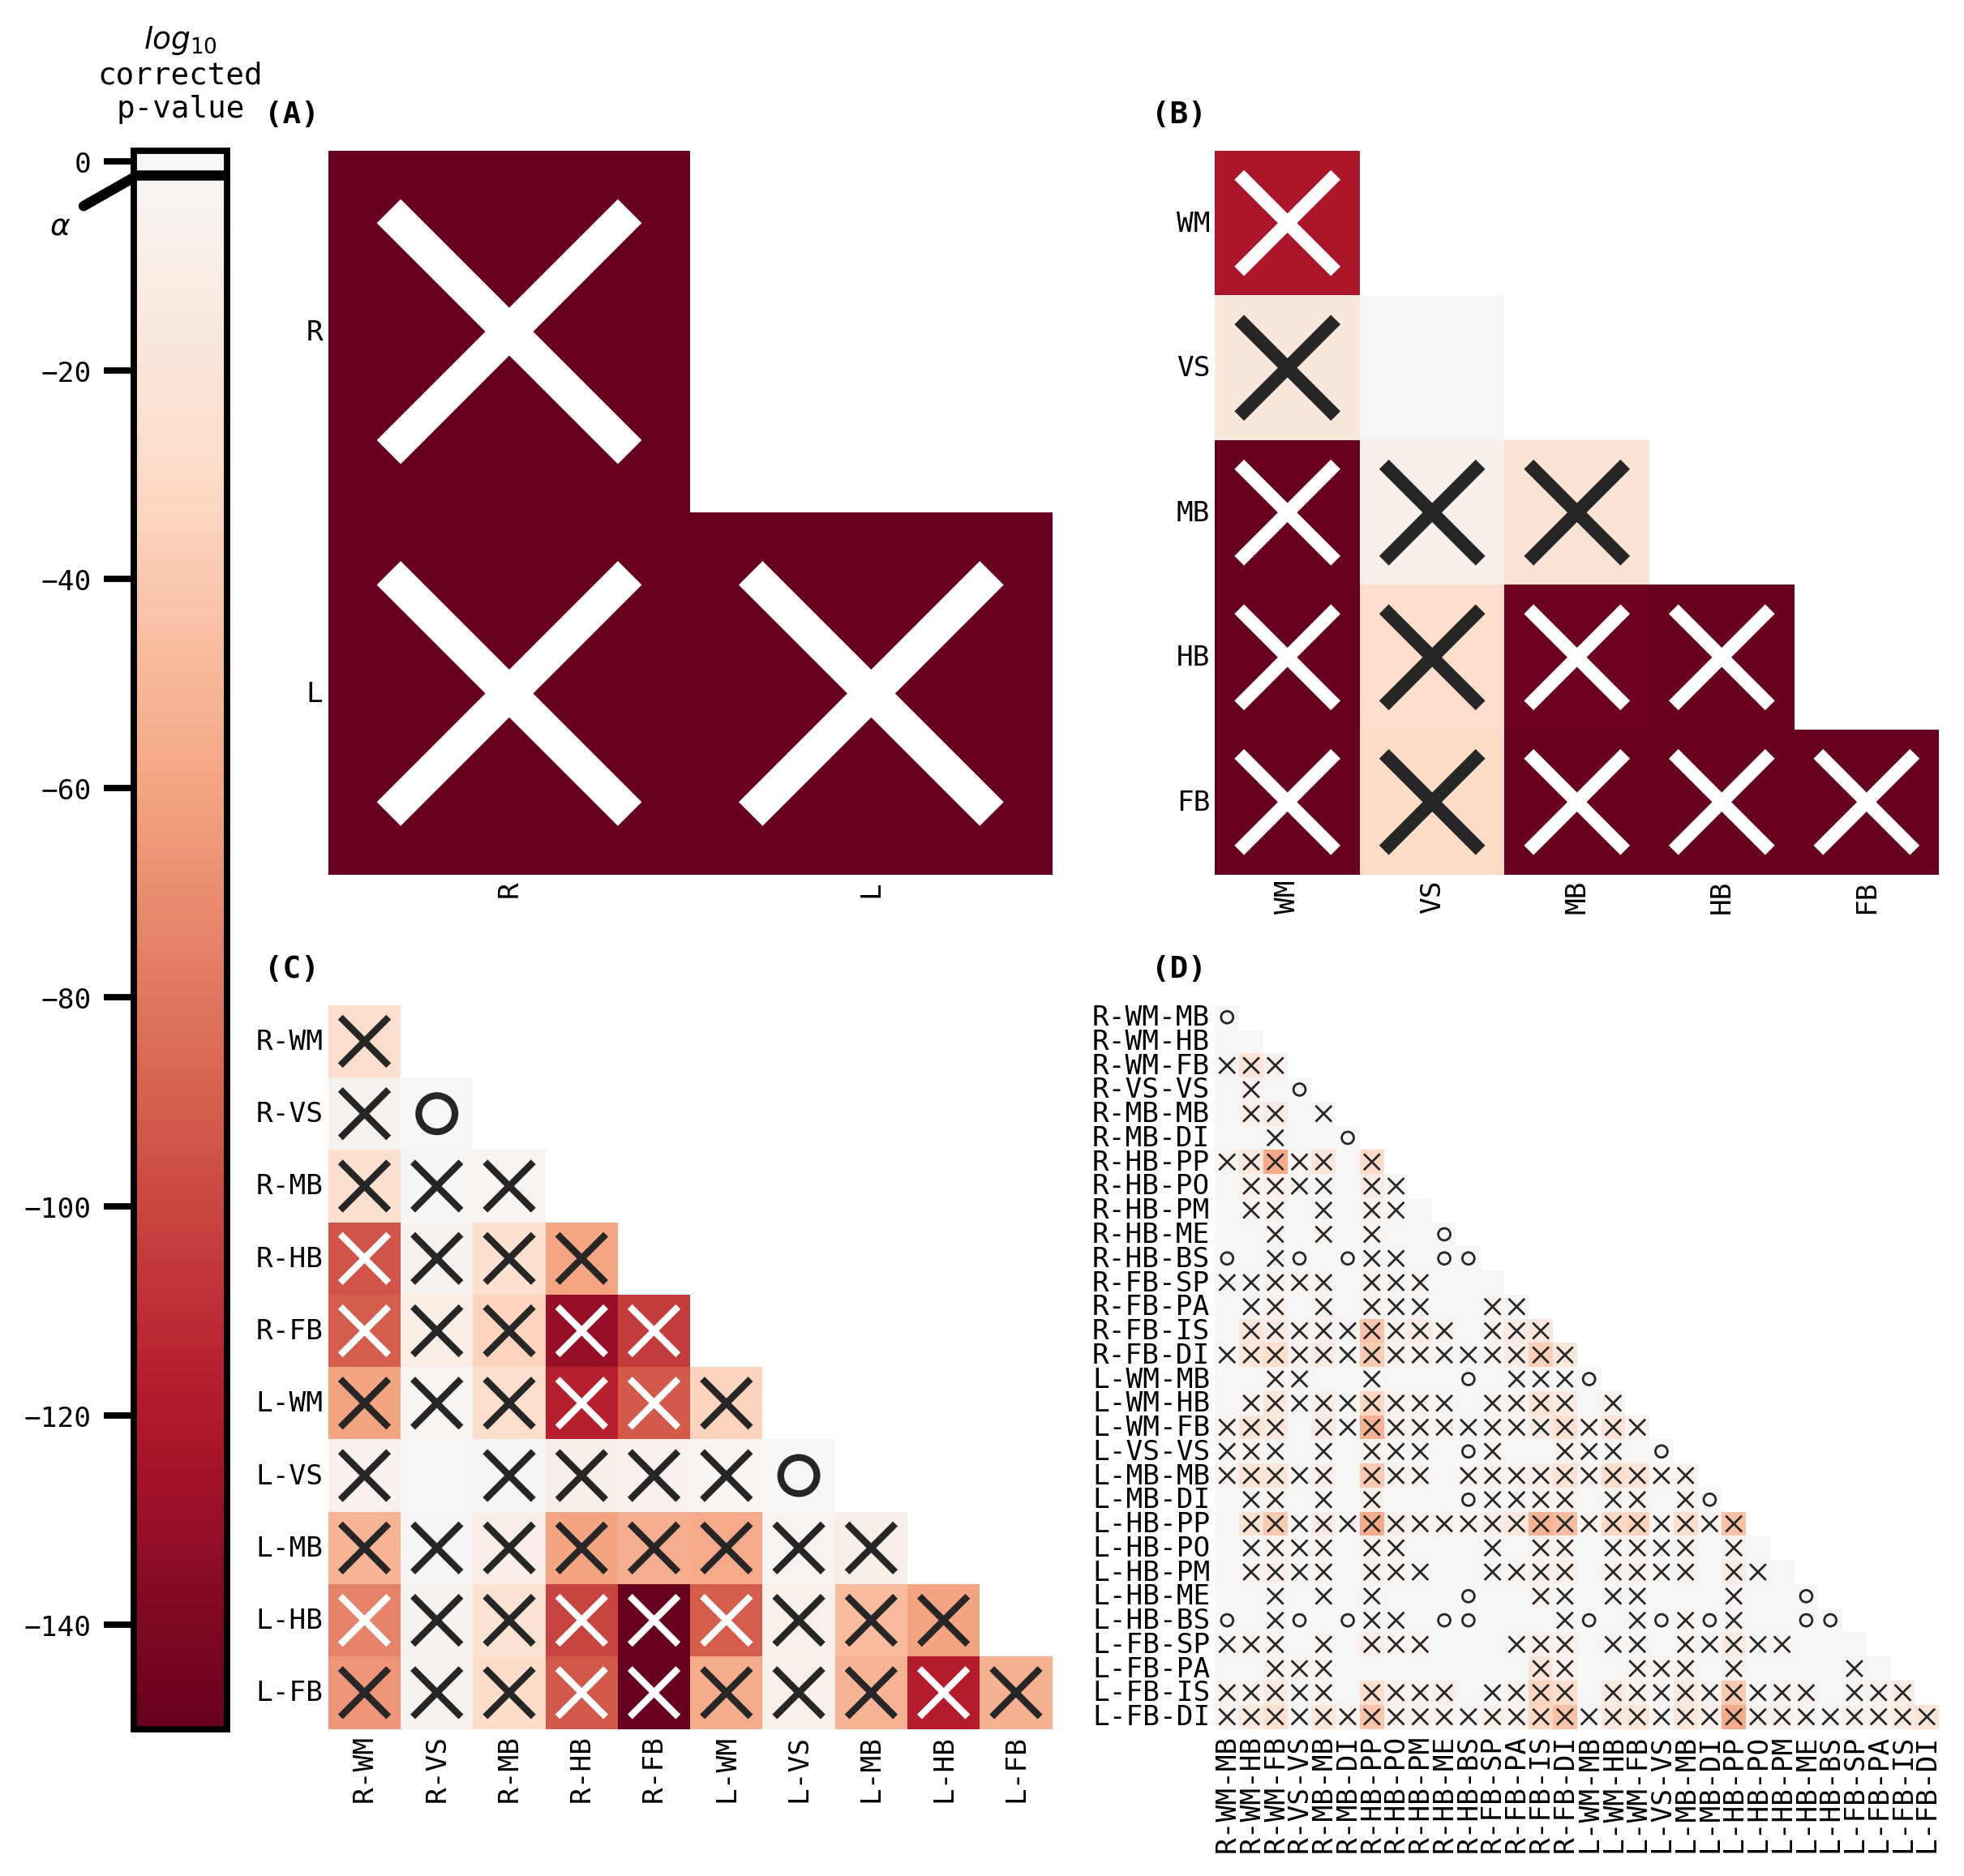

In [12]:
sns.set_context("talk", font_scale=0.5)
fig, _ = plot_heatmaps(dfs, True)

In [302]:
fig.savefig("./figures/apriori_ksample_volume.pdf")

## Do FA

In [13]:
correlations, labels = load_fa_corr()

In [14]:
dfs2 = [
    run_test(correlations, labels, idx, test="manova", absolute=True)
    for idx, labels in enumerate(
        [
            vertex_hemispheres,
            vertex_structures,
            vertex_hemisphere_structures,
            vertex_hemisphere_substructures,
        ]
    )
]

dfs2 = pd.concat(dfs2, ignore_index=True)

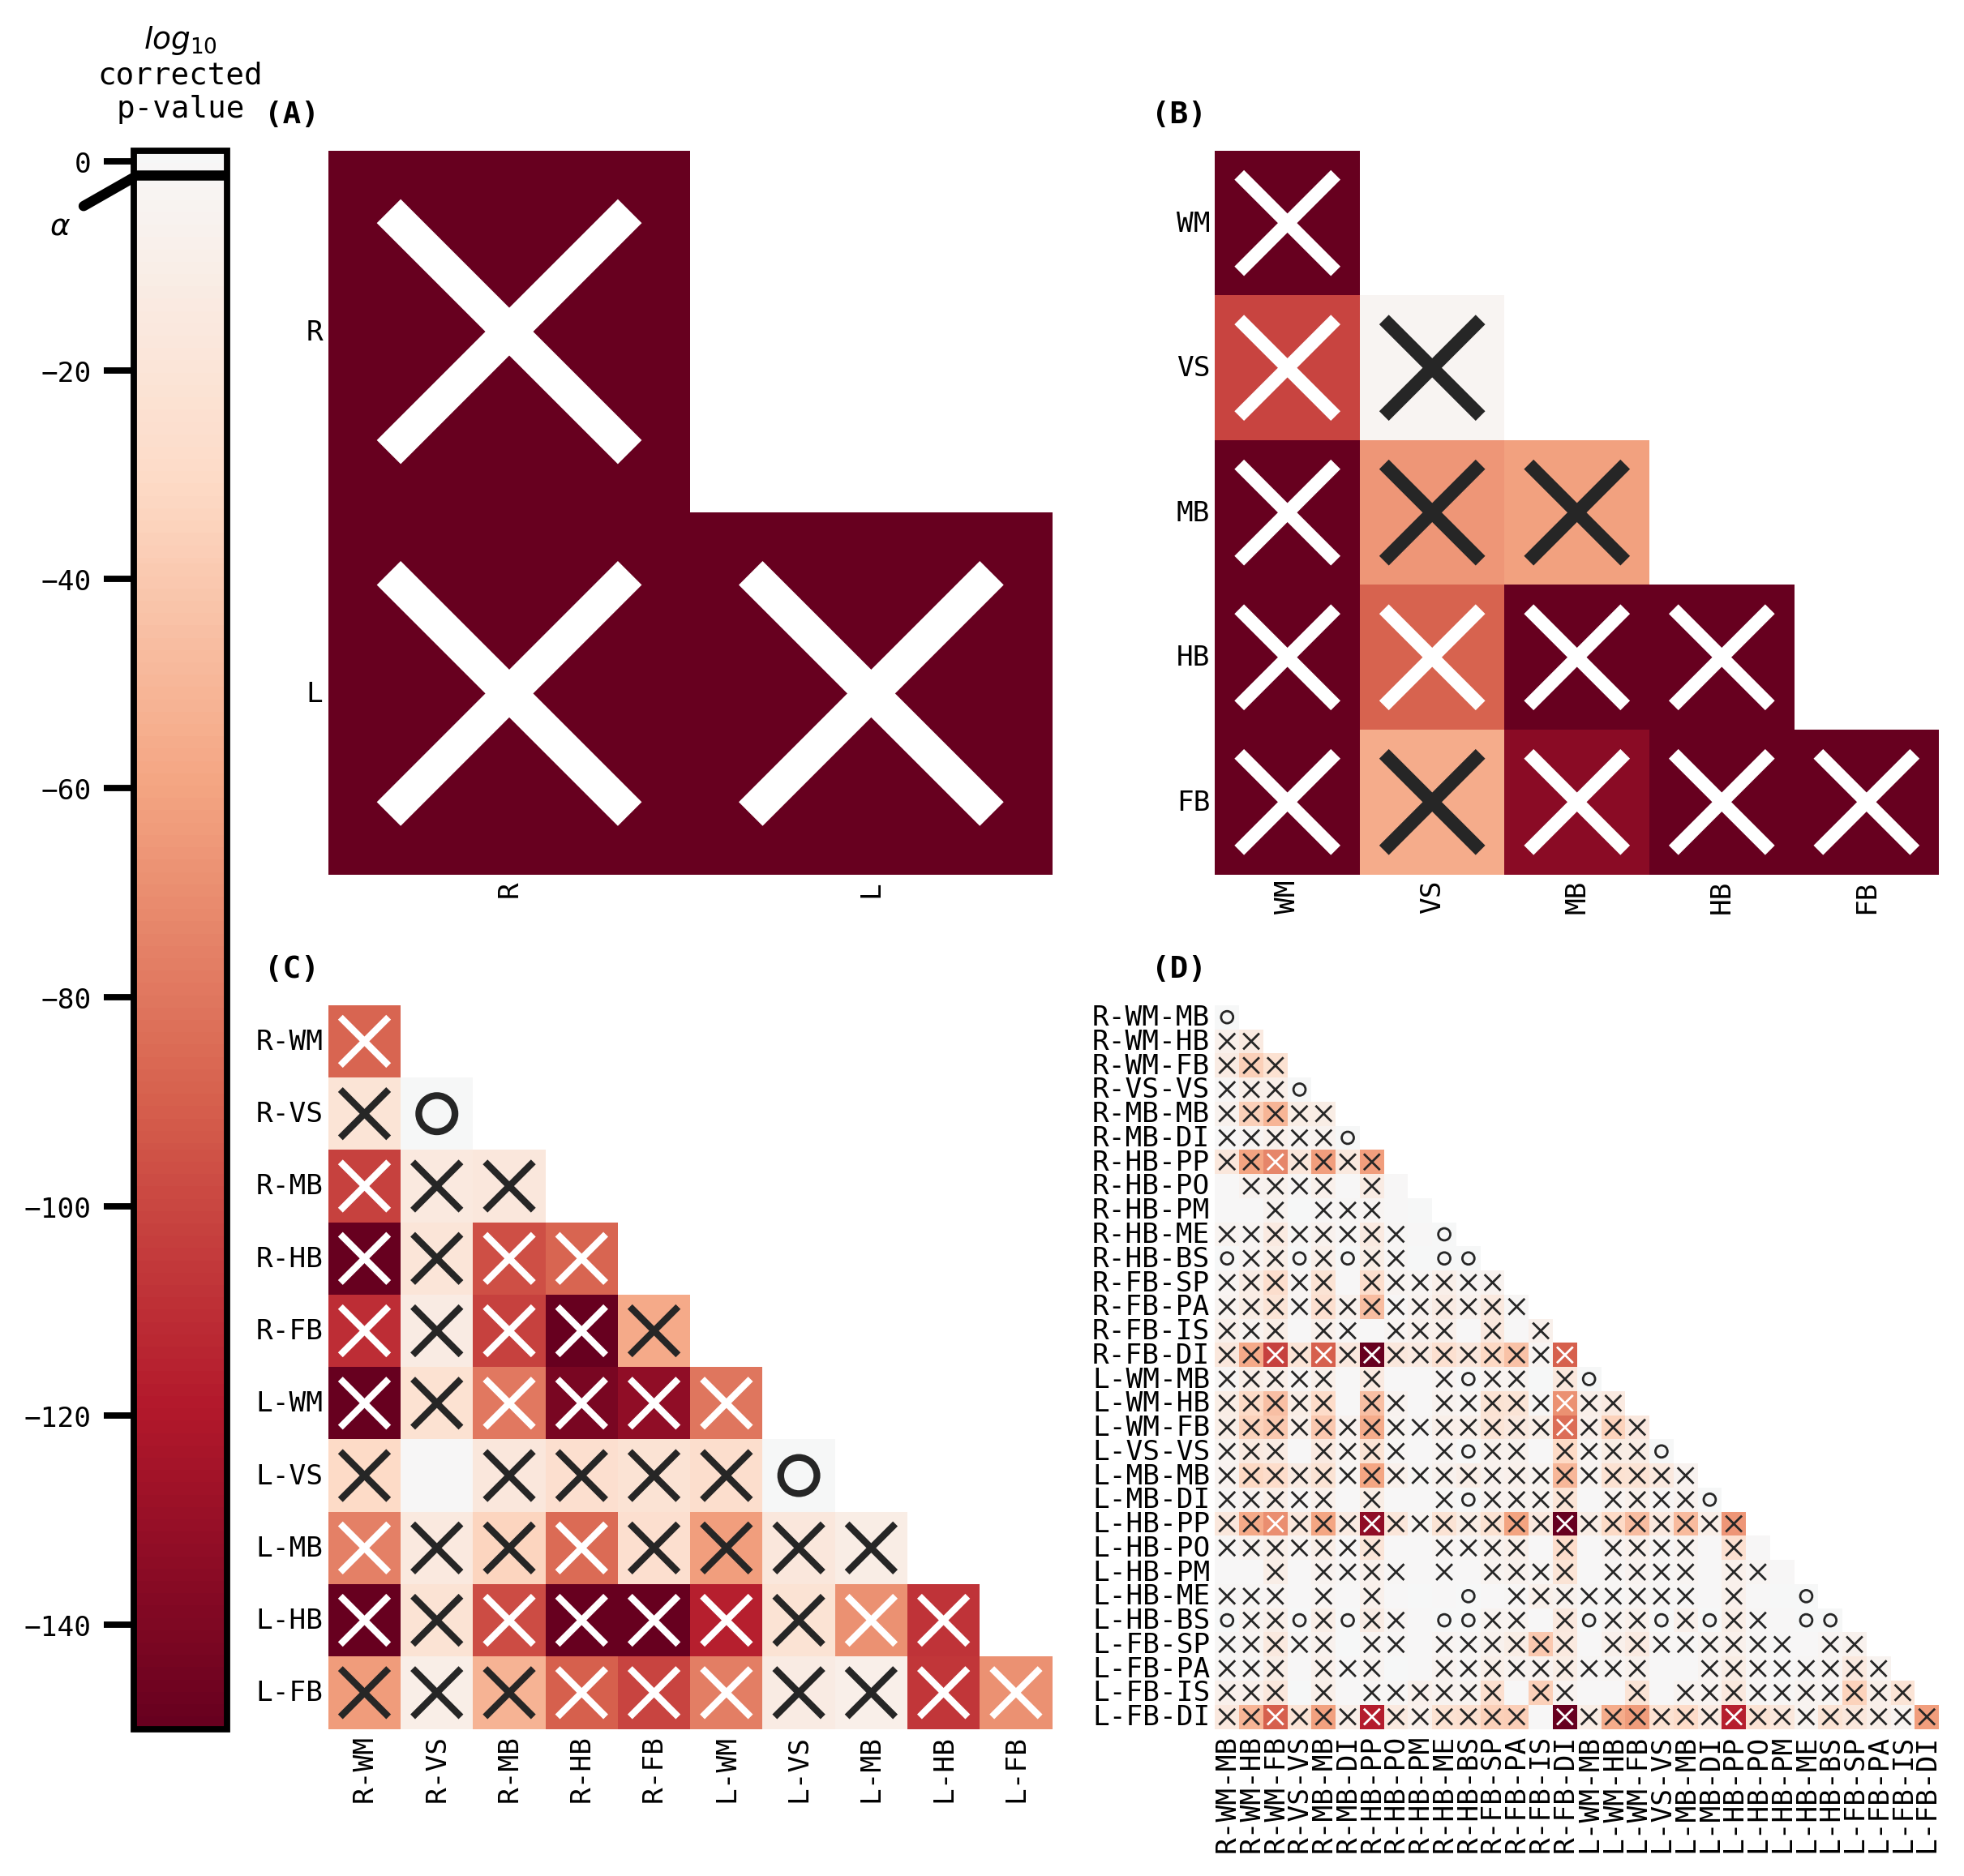

In [15]:
fig, _ = plot_heatmaps(dfs2, True)

fig.savefig("./figures/apriori_ksample_fa.pdf")

## Statistical Experiment

For a given pair of sub-regions (Left/Right Forebrain, Midbrain, Hindbrain, White Matter Tracts) $k$ and $l$, do the edges incident nodes between a pair of sub-regions have the same, or a different, distribution? Formally, consider the following model. Let $a_{ij}^{(y)}$ be the edge-weight for edge $i, j$, and let $z_i \in [K]$ be the node label for node $i$, where $y \in \{APOE22, APOE33, APOE44\}$ is the class of the network:

\begin{align*}
    a_{ij}^{(y)} | z_i = k, z_j = l \overset{ind.}{\sim} F^{(y)}_{k,l}
\end{align*}

where $F^{(y)}_{k,l}$ is the distribution function for the community of edges $k$ and $l$ in a network of class $y$. For a given tuple of node communities $(k,l)$ and $(k',l')$, the hypothesis of interest is:
\begin{align*}
    H_{0, k, l}^{(y, y')} : F^{(y)}_{k,l} = F^{(y')}_{k,l} \text{ against }H^{(y)}_{A, k,l}: F^{(y)}_{k,l} = F^{(y')}_{k,l}
\end{align*}

The interpretation of a $p$-value less than the cutoff threshold $\alpha = 0.05$ (after Bonferroni-Holm adjustment) for a given pair of classes $(y, y')$ at a given community pair $(k, l)$ is that the data does not support the null hypothesis, that the community pairing shares an equal distribution between the indicated pair of classes. A sufficient test for this context (univariate data, assumed to be independent, paired) is the Wilcoxon Signed-Rank Test, which can be performed using `scipy`.

The outcomes (p-values) can be visualized as pairs of heatmaps between a given pair of classes. Further, since the edges are undirected, we can ignore the off-diagonals of the matrix. These outcomes are then ranked, where a large rank indicates the smaller p-values.

In [93]:
def run_pairwise(
    graphs, graph_labels, vertex_labels, test="wilcoxon", absolute=False, reps=1000
):
    num_graphs = len(graphs)
    pairs = group_labels(vertex_labels)

    graph_pairs = list(combinations(range(3), 2))

    out = []

    for graph1, graph2 in graph_pairs:
        gs = [graphs[graph1], graphs[graph2]]

        for pair, (rdx, cdx) in pairs:
            num_verts = np.max([rdx.sum(), cdx.sum()])
            triu_idx = np.triu_indices(num_verts, k=1)

            if not np.all(rdx == cdx):  # deal with off diagonal blocks
                to_test = [g[rdx, :][:, cdx].ravel() for g in gs]
            else:  # when main diagonal block, only use upper triangle
                to_test = [g[rdx, :][:, cdx][triu_idx] for g in gs]

            if absolute:
                to_test = [np.abs(t) for t in to_test]

            if to_test[0].size <= 3:
                res = [np.nan, np.nan]
            else:
                if test.lower() == "dcorr":
                    res = KSample("Dcorr").test(
                        *to_test, auto=False, reps=reps, workers=-1
                    )
                elif test.lower() == "wilcoxon":
                    res = wilcoxon(*to_test)
                elif test.lower() == "mannwhitney":
                    res = mannwhitneyu(*to_test)
            # res = tester(*[np.abs(i) for i in to_test])
            stat, pval = res[:2]

            to_append = [*pair, stat, pval, graph_labels[graph1], graph_labels[graph2]]
            out.append(to_append)

    columns = ["region1", "region2", "statistic", "pvalue", "genotype1", "genotype2"]
    df = pd.DataFrame(out, columns=columns)

    non_nan = ~df.pvalue.isna()
    is_sig, corrected_pvalues, _, _ = multipletests(df[non_nan].pvalue, method="fdr_bh")
    df.loc[non_nan, "corrected_pvalue"] = corrected_pvalues
    df.loc[non_nan, "significant"] = is_sig

    return df

In [94]:
test2 = run_pairwise(
    correlations,
    GENOTYPES,
    vertex_hemisphere_substructures,
    absolute=False,
    test="mannwhitney",
)

In [95]:
test = test2

In [100]:
test.loc[:, ["genotype1", "genotype2"]].values

array([['APOE22', 'APOE33'],
       ['APOE22', 'APOE33'],
       ['APOE22', 'APOE33'],
       ...,
       ['APOE33', 'APOE44'],
       ['APOE33', 'APOE44'],
       ['APOE33', 'APOE44']], dtype=object)

In [102]:
pd.unique(test.loc[:, ["genotype1", "genotype2"]].values.ravel())

array(['APOE22', 'APOE33', 'APOE44'], dtype=object)

In [105]:
np.log10(test.corrected_pvalue.min())

-111.64129020271882

In [ ]:
def plot_pairwise(
    pairwise_df,
    ksample_df,
):
    n_plots = 3
    width_ratios = [0.5] + [4] * n_plots

    fig, axes = plt.subplots(
        ncols=4,
        nrows=1,
        figsize=(n_plots * 3.25 + 1, 3.8),
        dpi=300,
        gridspec_kw=dict(width_ratios=width_ratios),
        constrained_layout=True,
        # sharey=True,
    )

    # Subscript for ease
    cax = axes[0]
    axs = axes[1:]

    heatmap_kws = dict(
        cmap="RdBu",
        square=True,
        cbar=False,
        vmax=0,
        vmin=np.log10(df[~df.corrected_pvalue.isna()].corrected_pvalue).min(),
        fmt="s",
        center=0,
    )

    genotype_pairs = list(combinations(GENOTYPES, 2))

    for idx, (genotype1, genotype2) in enumerate(genotype_pairs):
        df = test[(test.genotype1 == genotype1) & (test.genotype2 == genotype2)]

        k = len(np.unique(df.region1))

        pvec = df.corrected_pvalue.values
        pvals = squareize(k, pvec)
        pvals[np.isnan(pvals)] = 1
        plot_pvalues = np.log10(pvals)
        if np.isinf(plot_pvalues).any():
            print(genotype1, genotype2)
            plot_pvalues[np.isinf(plot_pvalues)] = -150

        # Labels for x y axis
        labels = list(pd.unique(df.region1))

        # make mask
        triu_idx = np.triu_indices_from(pvals)
        mask = np.ones((k, k))
        mask[triu_idx] = 0

        ax = axs[idx]
        im = sns.heatmap(
            plot_pvalues,
            mask=mask,
            ax=ax,
            yticklabels=labels,
            xticklabels=labels,
            **heatmap_kws,
        )
        ax.tick_params(
            axis="y",
            labelrotation=0,
            pad=0.5,
            length=1,
            left=False,
        )

        if idx > 0:
            ax.set_yticklabels("")
        ax.tick_params(
            axis="x",
            labelrotation=90,
            pad=0.5,
            length=1,
            bottom=False,
        )

        ax.set_title(f"{genotype1} vs. {genotype2}")

    # Make x's and o's
    colors = im.get_children()[0].get_facecolors()
    raveled_idx = np.ravel_multi_index(triu_idx, plot_pvalues.shape)
    pad = 0.2
    for idx, is_significant, ksample_significant in zip(
        raveled_idx, df.significant, dfs[dfs.hierarchy_level == 3].significant
    ):
        i, j = np.unravel_index(idx, (k, k))

        # REF: seaborn heatmap
        lum = relative_luminance(colors[idx])
        text_color = ".15" if lum > 0.408 else "w"
        lw = 20 / k

        if ksample_significant == True:
            if is_significant == True:
                xs = [j + pad, j + 1 - pad]
                ys = [i + pad, i + 1 - pad]
                ax.plot(xs, ys, color=text_color, linewidth=lw)
                xs = [j + 1 - pad, j + pad]
                ys = [i + pad, i + 1 - pad]
                ax.plot(xs, ys, color=text_color, linewidth=lw)
            elif np.isnan(is_significant):
                circ = plt.Circle(
                    (j + 0.5, i + 0.5), 0.25, color=text_color, linewidth=lw, fill=False
                )
                ax.add_artist(circ)

    ax.invert_xaxis()
    ax.invert_yaxis()

    fig = axs[-1].get_figure()
    _ = fig.colorbar(
        im.get_children()[0],
        cax=cax,
        fraction=1,
        shrink=10,
        ticklocation="left",
    )
    cax.set_title(r"$log_{10}$" + "\ncorrected" "\np-value", pad=10)
    cax.plot(
        [0, 1],
        [np.log10(0.05), np.log10(0.05)],
        zorder=100,
        color="black",
        linewidth=3,
    )
    # cax.annotate(
    #     r"$\alpha$",
    #     (0.05, np.log10(0.05)),
    #     xytext=(-20, -15),
    #     textcoords="offset points",
    #     va="center",
    #     ha="right",
    #     arrowprops={"arrowstyle": "-", "linewidth": 3, "relpos": (0, 0.5)},
    # )
    
    return fig, axes

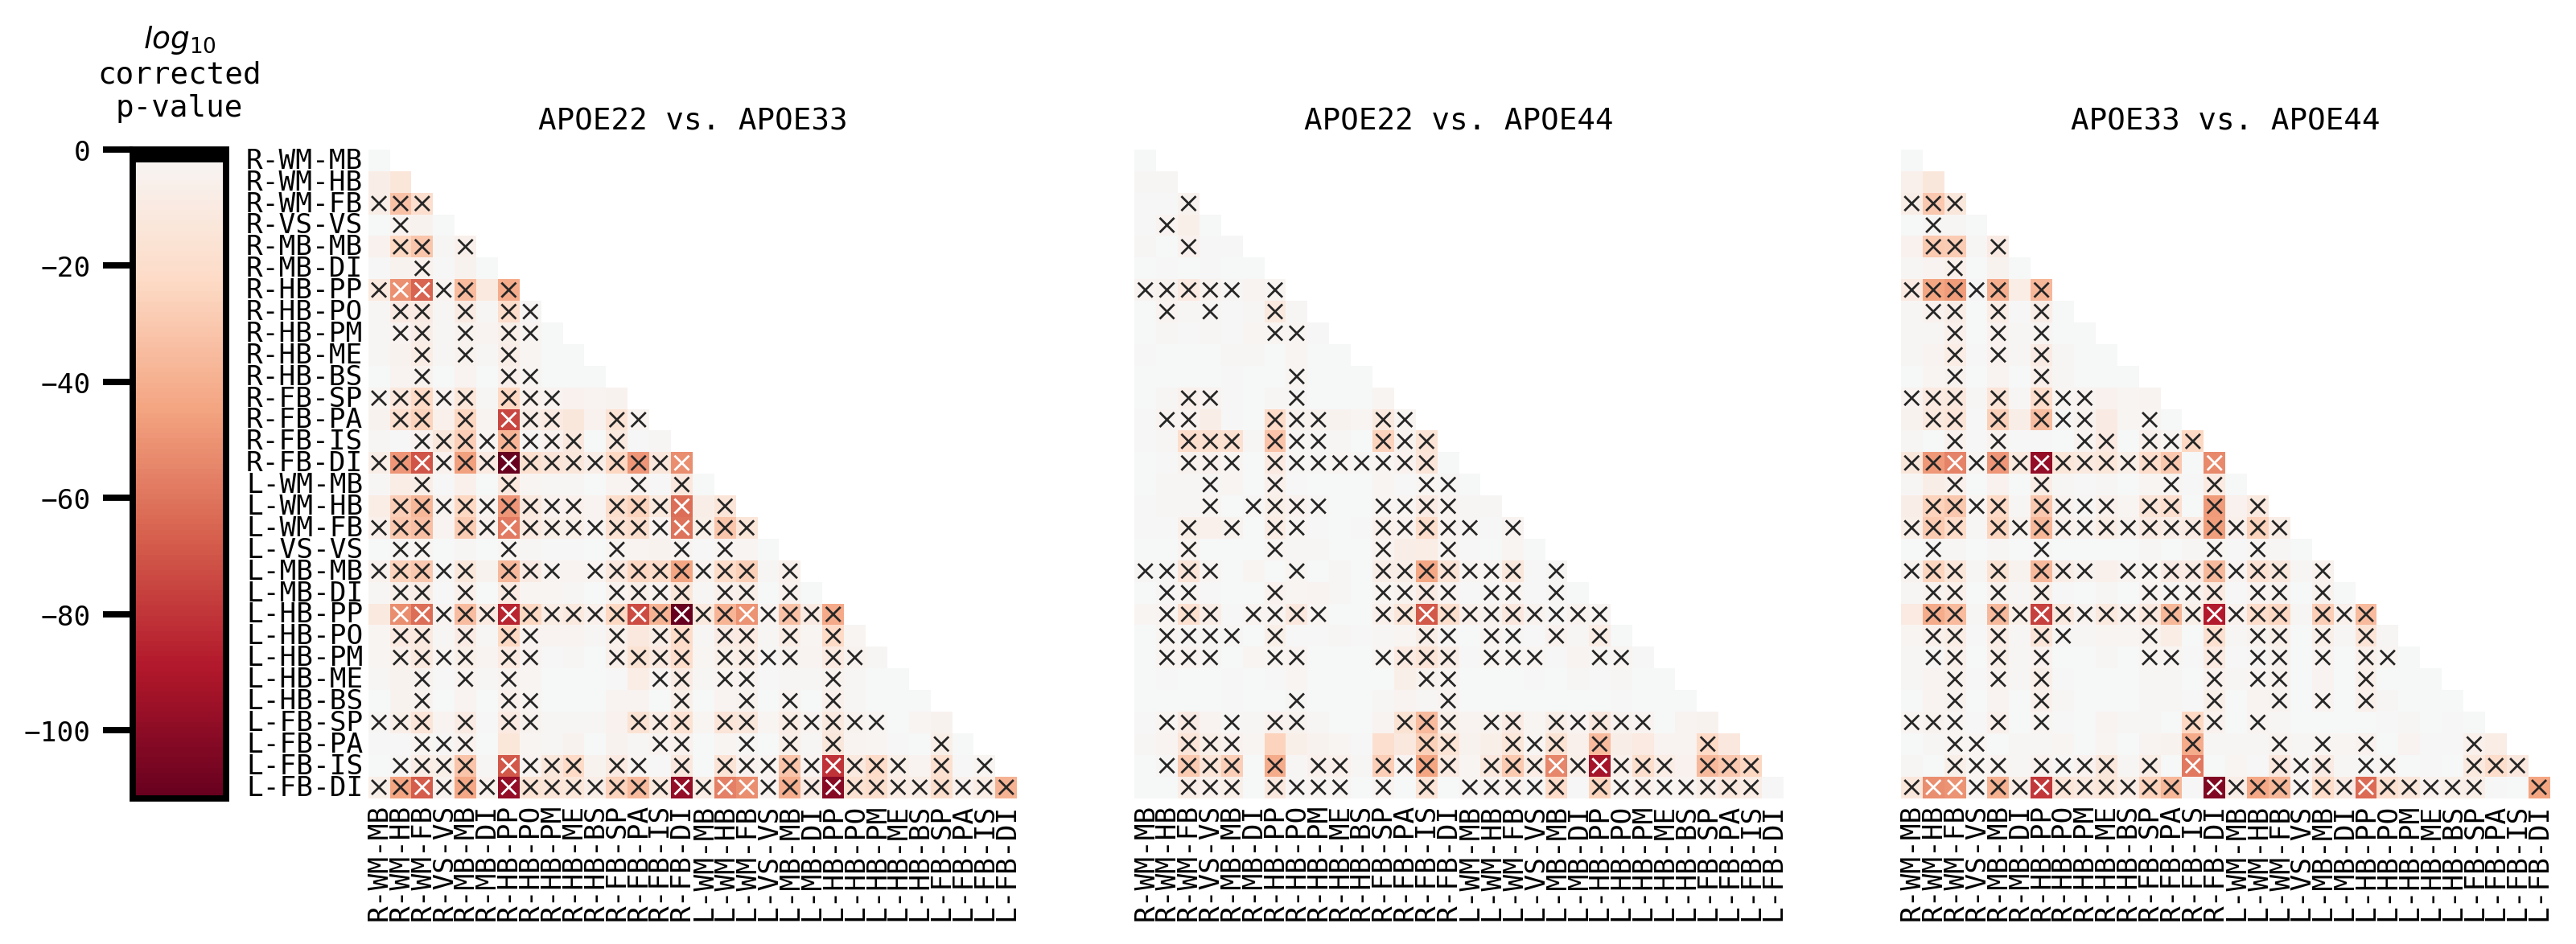

In [106]:
n_plots = 3

width_ratios = [0.5] + [4] * n_plots

fig, axes = plt.subplots(
    ncols=4,
    nrows=1,
    figsize=(n_plots * 3.25 + 1, 3.8),
    dpi=300,
    gridspec_kw=dict(width_ratios=width_ratios),
    constrained_layout=True,
    # sharey=True,
)

# Subscript for ease
cax = axes[0]
axs = axes[1:]

heatmap_kws = dict(
    cmap="RdBu",
    square=True,
    cbar=False,
    vmax=0,
    vmin=np.log10(test[~test.corrected_pvalue.isna()].corrected_pvalue).min(),
    fmt="s",
    center=0,
)

genotype_pairs = list(combinations(GENOTYPES, 2))

for idx, (genotype1, genotype2) in enumerate(genotype_pairs):
    df = test[(test.genotype1 == genotype1) & (test.genotype2 == genotype2)]

    k = len(np.unique(df.region1))

    pvec = df.corrected_pvalue.values
    pvals = squareize(k, pvec)
    pvals[np.isnan(pvals)] = 1
    plot_pvalues = np.log10(pvals)
    if np.isinf(plot_pvalues).any():
        print(genotype1, genotype2)
        plot_pvalues[np.isinf(plot_pvalues)] = -150

    # Labels for x y axis
    labels = list(pd.unique(df.region1))

    # make mask
    triu_idx = np.triu_indices_from(pvals)
    mask = np.ones((k, k))
    mask[triu_idx] = 0

    ax = axs[idx]
    im = sns.heatmap(
        plot_pvalues,
        mask=mask,
        ax=ax,
        yticklabels=labels,
        xticklabels=labels,
        **heatmap_kws,
    )
    ax.tick_params(
        axis="y",
        labelrotation=0,
        pad=0.5,
        length=1,
        left=False,
    )

    if idx > 0:
        ax.set_yticklabels("")
    ax.tick_params(
        axis="x",
        labelrotation=90,
        pad=0.5,
        length=1,
        bottom=False,
    )

    ax.set_title(f"{genotype1} vs. {genotype2}")

    # Make x's and o's
    colors = im.get_children()[0].get_facecolors()
    raveled_idx = np.ravel_multi_index(triu_idx, plot_pvalues.shape)
    pad = 0.2
    for idx, is_significant, ksample_significant in zip(
        raveled_idx, df.significant, dfs[dfs.hierarchy_level == 3].significant
    ):
        i, j = np.unravel_index(idx, (k, k))

        # REF: seaborn heatmap
        lum = relative_luminance(colors[idx])
        text_color = ".15" if lum > 0.408 else "w"
        lw = 20 / k

        if ksample_significant == True:
            if is_significant == True:
                xs = [j + pad, j + 1 - pad]
                ys = [i + pad, i + 1 - pad]
                ax.plot(xs, ys, color=text_color, linewidth=lw)
                xs = [j + 1 - pad, j + pad]
                ys = [i + pad, i + 1 - pad]
                ax.plot(xs, ys, color=text_color, linewidth=lw)
            elif np.isnan(is_significant):
                circ = plt.Circle(
                    (j + 0.5, i + 0.5), 0.25, color=text_color, linewidth=lw, fill=False
                )
                ax.add_artist(circ)

    ax.invert_xaxis()
    ax.invert_yaxis()

    fig = axs[-1].get_figure()
    _ = fig.colorbar(
        im.get_children()[0],
        cax=cax,
        fraction=1,
        shrink=10,
        ticklocation="left",
    )
    cax.set_title(r"$log_{10}$" + "\ncorrected" "\np-value", pad=10)
    cax.plot(
        [0, 1],
        [np.log10(0.05), np.log10(0.05)],
        zorder=100,
        color="black",
        linewidth=3,
    )
    # cax.annotate(
    #     r"$\alpha$",
    #     (0.05, np.log10(0.05)),
    #     xytext=(-20, -15),
    #     textcoords="offset points",
    #     va="center",
    #     ha="right",
    #     arrowprops={"arrowstyle": "-", "linewidth": 3, "relpos": (0, 0.5)},
    # )